Epoch 1/300


/Users/rafi/.local/share/mise/installs/python/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


760/760 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 25.7523 - mae: 4.5422 - val_loss: 2.2198 - val_mae: 1.1951 - learning_rate: 5.0000e-04
Epoch 2/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 4.4100 - mae: 1.5986 - val_loss: 1.0851 - val_mae: 0.8327 - learning_rate: 5.0000e-04
Epoch 3/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 2.9006 - mae: 1.2745 - val_loss: 1.5806 - val_mae: 1.0120 - learning_rate: 5.0000e-04
Epoch 4/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 2.0494 - mae: 1.0671 - val_loss: 1.4496 - val_mae: 0.9686 - learning_rate: 5.0000e-04
Epoch 5/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 1.1528 - mae: 0.8203 - val_loss: 0.9681 - val_mae: 0.7766 - learning_rate: 5.0000e-04
Epoch 6/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1.3019 - mae: 0.8759 - val_loss: 0.4970 - val_mae: 0.5535 - learning_rate: 5.0000e-04
Epoch 7/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 1.5914 - mae: 0.9413 - val_loss: 2.5483 - val_mae: 1.2

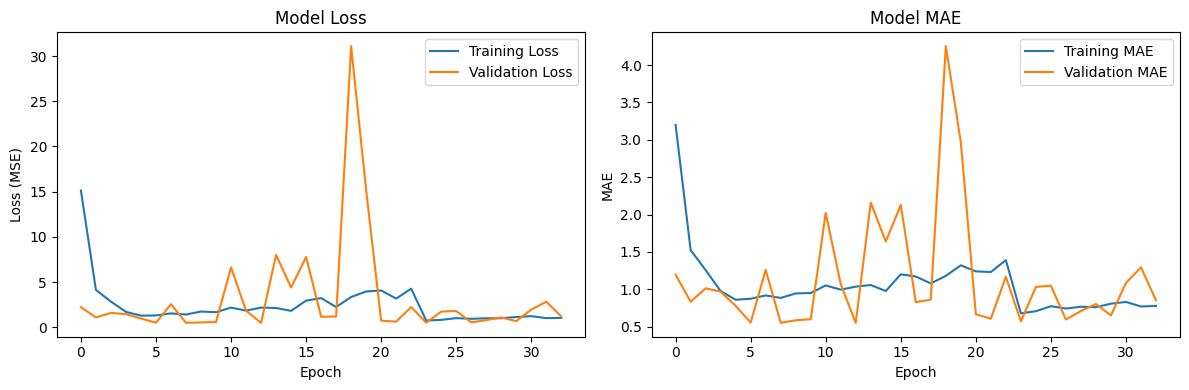

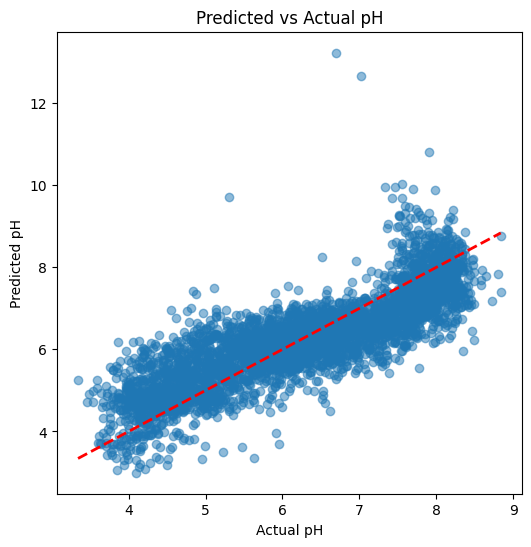

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Upload dataset
data = pd.read_csv("./lucas_pre.csv")

# Clean data and drop high-missingness columns
columns_to_drop = ["pH_H2O", "Depth", "CaCO3 (20-30 cm)", "OC (20-30 cm)", "Ox_Al", "Ox_Fe"]
data_clean = data.dropna(subset=["pH_H2O"])  # Drop rows where target is NaN
X = data_clean.drop(columns=columns_to_drop)
y = data_clean["pH_H2O"]

# Preprocessing
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")),
                ]
            ),
            cat_cols,
        ),
    ]
)
X_processed = preprocessor.fit_transform(X)
X_processed = np.nan_to_num(X_processed, nan=0.0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Improved FNN
model = Sequential(
    [
        Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(1),
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=0.00001)

# Train
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))
r2 = r2_score(y_test, y_pred)
print(f"\nImproved FNN Test MAE: {mae:.3f}")
print(f"Improved FNN R² Score: {r2:.3f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["mae"], label="Training MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Model MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()

# Plot predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Predicted vs Actual pH")
plt.show()